In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [5]:
X = df.drop('Drug', axis=1)
y = pd.DataFrame(df['Drug'])

cat_cols = list(X.select_dtypes('object').columns)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

X_train[cat_cols] = X_train[cat_cols].apply(lambda x: x.astype('category'))
X_valid[cat_cols] = X_valid[cat_cols].apply(lambda x: x.astype('category'))

sample_row = X.loc[0].to_dict()

In [6]:
cat_cols

['Sex', 'BP', 'Cholesterol']

In [7]:
model = LGBMClassifier()
# model = XGBClassifier(enable_categorical=True)
model.fit(
    X_train, 
    y_train
    # categorical_feature=cat_cols,
    # verbose_eval=-1
    )

preds = model.predict(X_valid)
print(f'accuracy: {accuracy_score(y_valid, preds)}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 5
[LightGBM] [Info] Start training from score -0.830769
[LightGBM] [Info] Start training from score -2.051271
[LightGBM] [Info] Start training from score -2.376693
[LightGBM] [Info] Start training from score -2.456736
[LightGBM] [Info] Start training from score -1.358123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


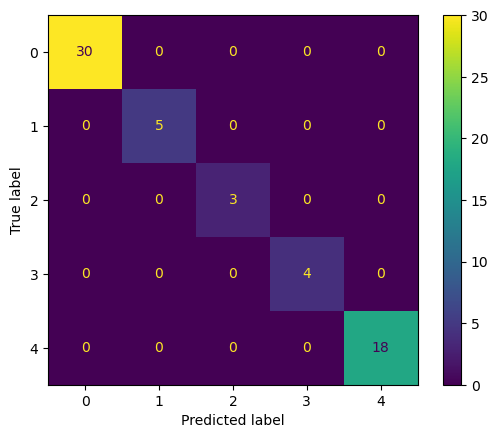

In [8]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

In [9]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [13]:
from pydantic import BaseModel, ValidationError

class Drug(BaseModel):
    Age: int
    Sex: object
    BP: object
    Cholesterol: object
    Na_to_K: float

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print(sample_row)
drug = Drug(**sample_row)
inputs = pd.DataFrame([drug.model_dump()])
inputs[cat_cols] = inputs[cat_cols].apply(lambda row: row.astype('category'))
pred = loaded_model.predict(inputs)[0]
pred




{'Age': 23, 'Sex': 'F', 'BP': 'HIGH', 'Cholesterol': 'HIGH', 'Na_to_K': 25.355}


'DrugY'

In [11]:
from flask import Flask, jsonify, request

app = Flask(__name__)


@app.route('/predict', methods=['POST'])
def predict():
    try:
        print(request.json)
        drug = Drug(**request.json)
        inputs = pd.DataFrame([drug.model_dump()])
        inputs[cat_cols] = inputs[cat_cols].apply(lambda row: row.astype('category'))
        pred = loaded_model.predict(inputs)[0]

        response = {
            'prdiction': pred
        }

        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400


if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


SystemExit: 1

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
